## Visualize signature features

There are a total of 45 features in the signature.

We add a visualization here to observe a birds eye view of what is going on.

### We split the features into three categories

1. AreaShape
2. Correlation (it involves two channels)
3. Other feature groups (e.g., texture, intensity, radial distribution)

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))

In [2]:
output_file <- file.path("figures", "bortezomib_signature_interpretation_summary.png")

In [3]:
signature_dir <- file.path("..", "3.resistance-signature", "results", "signatures")
bz_signature_file <- file.path(
    signature_dir,
    "signature_summary_bortezomib_signature.tsv.gz"
)
tukey_direction_file <- file.path(
    signature_dir,
    "tukey_results_bortezomib_signature.tsv.gz"
)

In [4]:
# Load signature and parse out feature categories
sig_df <- readr::read_tsv(bz_signature_file, show_col_types = FALSE) %>%
    dplyr::filter(final_signature) %>% # Filter to the final features 
    tidyr::separate(
        features,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

# Clean up the channel name for easy plotting
sig_df$channel_cleaned <- dplyr::recode(sig_df$channel_cleaned,
    "DNA" = "DNA",
    "ER" = "ER",
    "AGP" = "AGP",
    "Mito" = "Mito",
    "RNA" = "RNA",
    .default = "other",
    .missing = "other"
)

# Create factor for plotting later as well
sig_df$channel_cleaned <- factor(
    sig_df$channel_cleaned,
    levels = rev(c("AGP", "DNA", "ER", "Mito", "RNA", "other"))
)

# What are the features (for filtering tukey estimate)
sig_features <- sig_df %>% dplyr::pull(features)

# Load tukey results (directionality of each feature and score)
tukey_df <- readr::read_tsv(tukey_direction_file, show_col_types = FALSE) %>%
    dplyr::filter(
        feature %in% sig_features,
        term == "Metadata_clone_type_indicator"
    ) %>%
    dplyr::mutate(high_or_low = ifelse(estimate < 0, "Low in\nresistant cells", "High in\nresistant cells")) %>%
    dplyr::select(feature, high_or_low, estimate)

# Merge signature with tukey and select important columns
sig_df <- sig_df %>%
    dplyr::left_join(tukey_df, by = c("features" = "feature")) %>%
    dplyr::select(
        features,
        compartment,
        feature_group,
        measurement,
        channel,
        parameter1,
        parameter2,
        channel_cleaned,
        high_or_low,
        estimate
    ) %>%
    dplyr::mutate(area_shape_indicator = paste(measurement, channel, parameter1, sep = "_"))

print(dim(sig_df))
head(sig_df, 3)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 29 rows [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18,
19, 20, 21, 22, 23, ...].”


[1] 45 11


features,compartment,feature_group,measurement,channel,parameter1,parameter2,channel_cleaned,high_or_low,estimate,area_shape_indicator
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>
Cells_AreaShape_Zernike_4_2,Cells,AreaShape,Zernike,4,2,NA,other,Low in resistant cells,-0.4757422,Zernike_4_2
Cells_Correlation_K_DNA_AGP,Cells,Correlation,K,DNA,AGP,NA,DNA,High in resistant cells,0.5400484,K_DNA_AGP
Cells_Correlation_Manders_Mito_ER,Cells,Correlation,Manders,Mito,ER,NA,Mito,Low in resistant cells,-0.7571714,Manders_Mito_ER


In [5]:
# For consistent scale bars and plotting
min_estimate = min(sig_df$estimate)
max_estimate = max(sig_df$estimate)

point_size = 11
text_size = 4

# Add visualizations

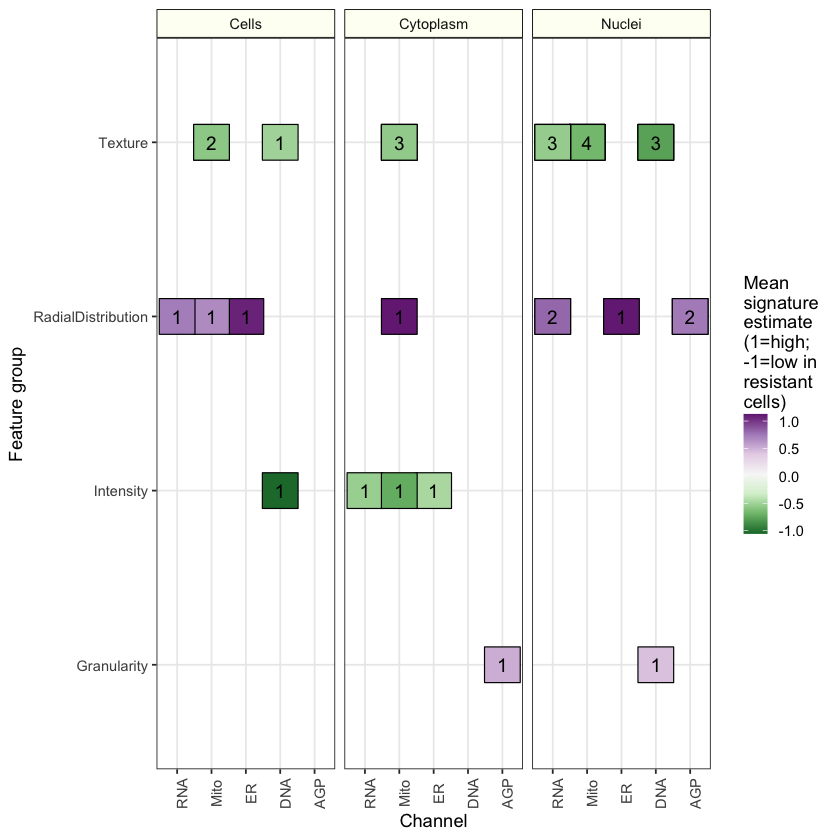

In [6]:
# Process data for plotting
other_feature_group_df <- sig_df %>%
    dplyr::filter(!feature_group %in% c("AreaShape", "Correlation"))

other_feature_group_count <- other_feature_group_df %>%
    dplyr::group_by(high_or_low, compartment, channel_cleaned, feature_group) %>%
    dplyr::count()

other_feature_group_df <- other_feature_group_df %>%
    dplyr::group_by(high_or_low, compartment, channel_cleaned, feature_group) %>%
    dplyr::mutate(mean_estimate = mean(estimate)) %>%
    dplyr::select(features, compartment, feature_group, channel_cleaned, high_or_low, mean_estimate) %>%
    dplyr::distinct()

# Plot for other feature groups
other_feature_group_gg <- (
    ggplot(
        other_feature_group_df,
        aes(x = channel_cleaned, y = feature_group)
    )
    + geom_point(
        aes(fill = mean_estimate), 
        shape = 22,
        size = point_size
    )
    + geom_text(
        data = other_feature_group_count,
        aes(label = n),
        size = text_size,
        color = "black"
    )
    + facet_grid("~compartment")
    + theme_bw()
    + theme(
        axis.text.x = element_text(angle = 90),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(x = "Channel", y = "Feature group")
    + scale_fill_distiller(
        name = "Mean\nsignature\nestimate\n(1=high;\n-1=low in\nresistant\ncells)",
        palette = "PRGn",
        limits = c(min_estimate, max_estimate)
    )
)

other_feature_group_gg

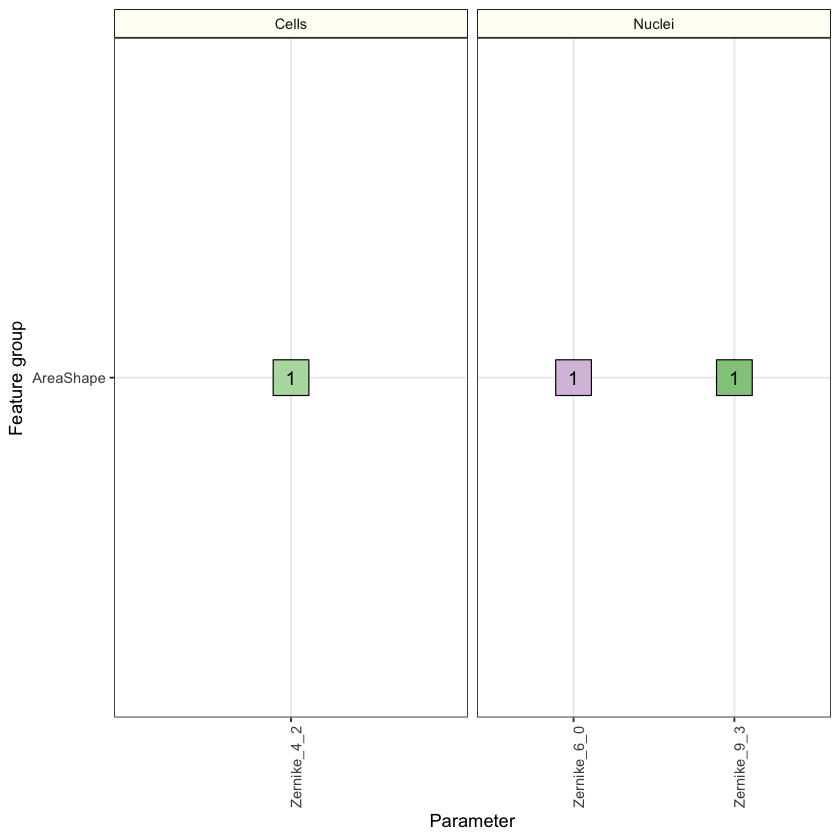

In [7]:
area_shape_df <- sig_df %>% dplyr::filter(feature_group  == "AreaShape")

area_shape_group_count <- area_shape_df %>%
    dplyr::group_by(high_or_low, compartment, channel_cleaned, area_shape_indicator, feature_group) %>%
    dplyr::count()

area_shape_df <- area_shape_df %>%
    dplyr::group_by(high_or_low, compartment, channel_cleaned, area_shape_indicator, feature_group) %>%
    dplyr::mutate(mean_estimate = mean(estimate)) %>%
    dplyr::select(features, compartment, feature_group, channel_cleaned, area_shape_indicator, high_or_low, mean_estimate) %>%
    dplyr::distinct()

# Plot for area shape
area_shape_gg <- (
    ggplot(
        area_shape_df,
        aes(x = area_shape_indicator, y = feature_group)
    )
    + geom_point(aes(fill = mean_estimate), shape = 22, size = point_size)
    + geom_text(
        data = area_shape_group_count,
        aes(label = n),
        size = text_size,
        color = "black"
    )
    + facet_grid("~compartment", scales = "free")
    + theme_bw()
    + theme(
        axis.text.x = element_text(angle = 90),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none"
    )
    + labs(x = "Parameter", y = "Feature group")
    + scale_fill_distiller(
        name = "Mean\nsignature\nestimate\n(1=high;\n-1=low in\nresistant\ncells)",
        palette = "PRGn",
        limits = c(min_estimate, max_estimate)
    )
)

area_shape_gg

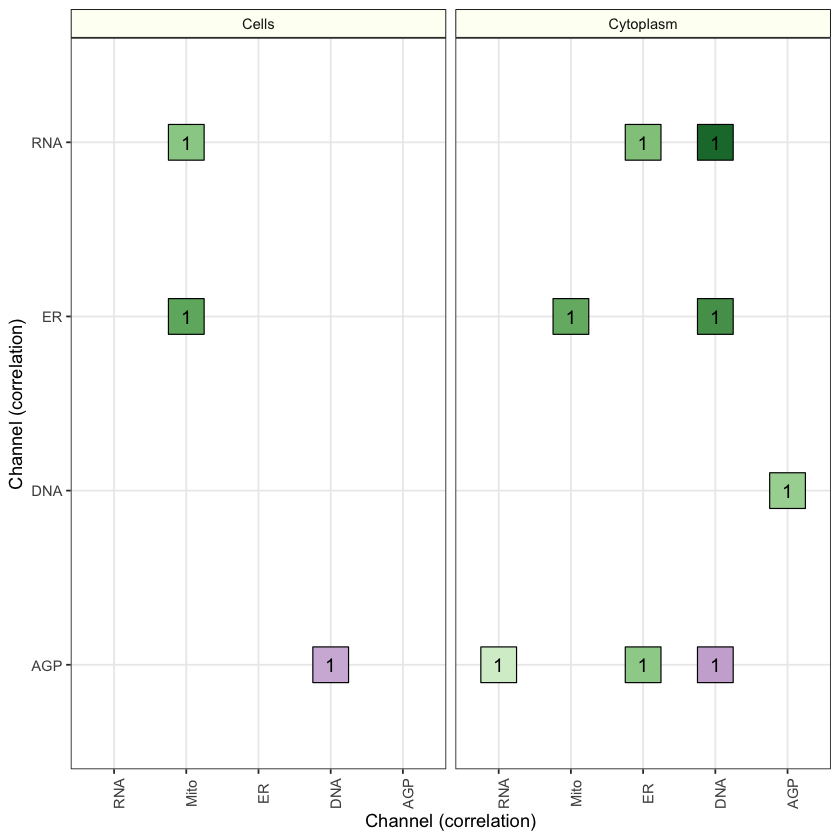

In [8]:
correlation_df <- sig_df %>% dplyr::filter(feature_group  == "Correlation")

correlation_group_count <- correlation_df %>%
    dplyr::group_by(high_or_low, compartment, parameter1, channel_cleaned, area_shape_indicator, feature_group) %>%
    dplyr::count()

correlation_df <- correlation_df %>%
    dplyr::group_by(high_or_low, compartment, channel_cleaned, parameter1, feature_group) %>%
    dplyr::mutate(mean_estimate = mean(estimate)) %>%
    dplyr::select(features, compartment, feature_group, channel_cleaned, parameter1, high_or_low, mean_estimate) %>%
    dplyr::distinct()

# Plot for correlation
correlation_gg <- (
    ggplot(
        correlation_df,
        aes(x = channel_cleaned, y = parameter1)
    )
    + geom_point(aes(fill = mean_estimate), shape = 22, size = point_size)
    + geom_text(
        data = correlation_group_count,
        aes(label = n),
        size = text_size,
        color = "black"
    )
    + facet_grid("~compartment")
    + theme_bw()
    + theme(
        axis.text.x = element_text(angle = 90),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none"
    )
    + labs(x = "Channel (correlation)", y = "Channel (correlation)")
    + scale_fill_distiller(
        name = "Mean\nsignature\nestimate\n(1=high;\n-1=low in\nresistant\ncells)",
        palette = "PRGn",
        limits = c(min_estimate, max_estimate)
    )
)

correlation_gg

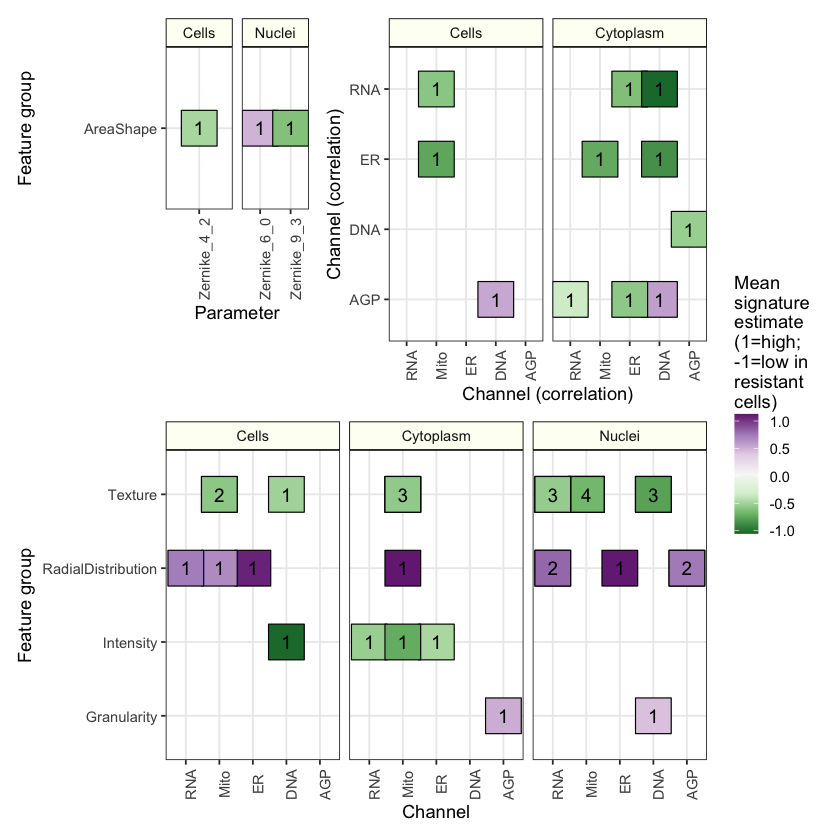

In [9]:
patchwork_plot <- (
    (
        (
            (
                (
                    area_shape_gg / plot_spacer()
                ) + plot_layout(heights = c(1, 0.002))
            )
            | correlation_gg
        ) + plot_layout(widths = c(0.45, 1))
    ) /
    other_feature_group_gg
) + plot_layout(guides = "collect", heights = c(0.95, 1))

ggsave(output_file, patchwork_plot, height = 5, width = 8.4, dpi = 500)

patchwork_plot